In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.special import legendre
from scipy.special import hermite
import copy
import pandas as pd
from scipy import integrate
from scipy.special import comb
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm

In [2]:
'''
https://people.sc.fsu.edu/~jburkardt/py_src/monomial/monomial.py
Finds the next monomial multi-index, as explained in the lecture

'''

def next_monomial(m,x):
    j = 0

    for i in range ( 1, m ):
        if ( 0 < x[i] ):
            j = i
            break

    if ( j == 0 ):
        t = x[0]
        x[0] = 0
        x[m-1] = t + 1
    elif ( j < m - 1 ):
        x[j] = x[j] - 1
        t = x[0] + 1;
        x[0] = 0;
        x[j-1] = x[j-1] + t
    elif ( j == m - 1 ):
        t = x[0]
        x[0] = 0
        x[j-1] = t + 1
        x[j] = x[j] - 1

    return x

In [68]:
def f(z1, z2):
    return -abs(z1)**3*z2+np.exp(-(z1-0.5)**2-0.25*z2**2)

In [4]:
M = 1000000
Z = np.zeros((M,2))

Z[:,0] = np.random.uniform(size=M) * 2 - 1
Z[:,1] = np.random.uniform(size=M) * 2 - 1

f_real = f(Z[:,0],Z[:,1])

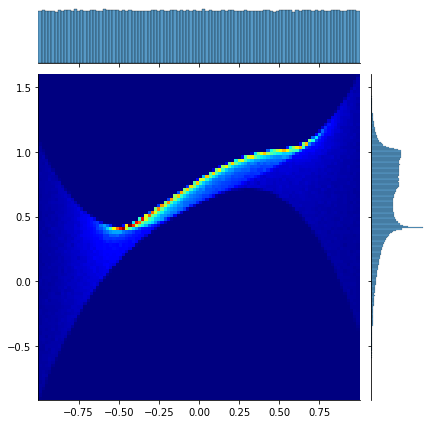

In [5]:
x = Z[:,0]
y = f_real

ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.hist2d(x, y, bins=(100, 100), cmap=cm.jet);

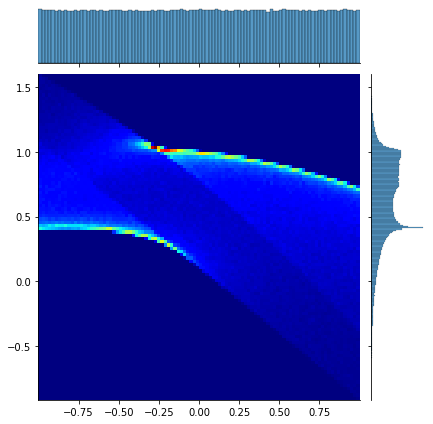

In [6]:
x = Z[:,1]
y = f_real

ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.hist2d(x, y, bins=(100, 100), cmap=cm.jet);

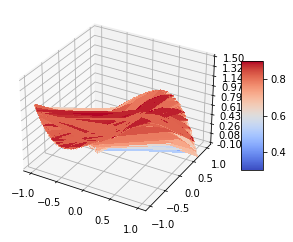

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = Z[1:1000,0]
Y = Z[1:1000,1]
X, Y = np.meshgrid(X, Y)
R = f(X,Y)

surf = ax.plot_surface(X, Y, R, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-.1, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

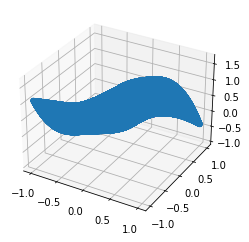

In [8]:
ax = plt.axes(projection='3d')
ax.scatter3D(Z[:,0], Z[:,1], f_real)

In [9]:
N = 2
M = N+1
D=2

In [10]:
x, w = np.polynomial.legendre.leggauss(M)

In [11]:
c=np.zeros(N+1); g=np.zeros(N+1);

In [12]:
# computational grid
l =-1
r=1
dz=0.001;

z=np.linspace(l,r,int((r-l) / dz));
J=len(z)-1;
p1=np.zeros((N+1,J+1)); 
p2=np.zeros((N+1,J+1)); 

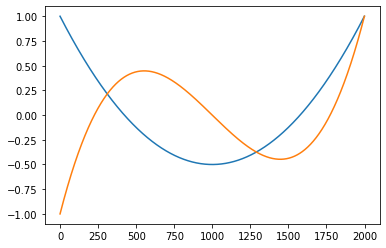

In [13]:
# nice legendre poly's
i=4

plt.plot(legendre(i-2)(z))
plt.plot(legendre(i-1)(z))

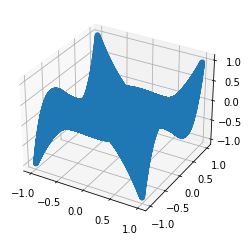

In [14]:
ax = plt.axes(projection='3d')
ax.scatter3D(Z[:,0], Z[:,1], legendre(i-2)(Z[:,0]) * legendre(i-1)(Z[:,1]))

In [110]:
# build monomial multi indices
monomial={}
x=np.array([0,0])
D = 2
N=4
set_size = int(comb(N+D,N))

for i in range(set_size):
    monomial[i] = x.copy()
    x = next_monomial(D,x)

In [16]:
# finding gamma

In [111]:
# numerical solution in 1D
i=4

f_gamma = lambda x, i: legendre(i-1)(x)* legendre(i-1)(x) 

integrate.quadrature(f_gamma, -1,1, args=(i))[0]

0.28571428571428537

In [112]:
# analytical solution in 1 D
2/(2*i-1)

0.2857142857142857

In [113]:
# function to get the multi index gamma from a multi index
def get_gamma(multi_index):
    gammas = np.zeros(len(monomial[multi_index]))
    for index, i in enumerate(monomial[multi_index]):
        gammas[index] = integrate.quadrature(f_gamma, -1,1, args=(i+1))[0]
    return np.product(gammas)

In [114]:
def phi(multi_index, Z):
    ans = legendre(monomial[multi_index][0])(Z[0])
    for i in range(1, len(monomial[multi_index])):
        ans*=legendre(monomial[multi_index][i])(Z[i])
    return ans

In [115]:
def f_hat(z1,z2, multi_index, nothing):
    Z = [z1,z2]
    return f(z1,z2) * phi(multi_index, Z)

In [116]:
def f_func(z1,z2,multi_index, nothing):
    Z = [z1,z2]
    return f(z1,z2) * phi(multi_index, Z)

def l_func(z1,z2,multi_index,nothing):
    Z = [z1,z2]
    return phi(multi_index, Z) * phi(multi_index, Z)

In [121]:
x, w = np.polynomial.legendre.leggauss(len(monomial.keys()))

In [122]:
c = np.zeros(len(x))
g = np.zeros(c.shape)

In [155]:
ans = 0
for i, multi_index in enumerate(monomial.keys()):
    c[i] = integrate.nquad(f_func, ((-1,1), (-1,1)), args=(multi_index, 1))[0]
    g[i] = integrate.nquad(l_func, ((-1,1), (-1,1)), args=(multi_index, 1))[0]

In [126]:
Z = np.array((np.random.uniform(size=100)*2-1, np.random.uniform(size=100)*2-1))

In [127]:
p=np.zeros((len(monomial.keys()),len(Z[0])))
for i, multi_index in enumerate(monomial.keys()):
    p[i,:] = phi(multi_index, Z)

In [129]:
f_real = f(Z[0], Z[1])

In [157]:
f_a = np.zeros(f_real.shape)

for i, multi_index in enumerate(monomial.keys()):
    f_a += (c[i]/g[i])*p[i]

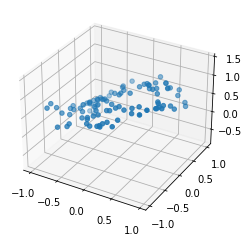

In [158]:
ax = plt.axes(projection='3d')
ax.scatter3D(Z[0],Z[1], f_real)

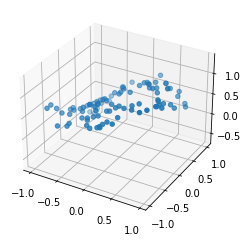

In [159]:
ax = plt.axes(projection='3d')
ax.scatter3D(Z[0],Z[1], f_a)